In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.datasets.utils import download_url
from torchvision.datasets import CIFAR10
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

In [2]:
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

train_transforms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                               tt.RandomHorizontalFlip(),
#                                tt.RandomRotation(20),
#                                tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                               tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                               tt.ToTensor(), 
                               tt.Normalize(*stats,inplace=True)])

valid_transforms = tt.Compose([tt.ToTensor(), 
                               tt.Normalize(*stats)])

In [3]:
train_data = CIFAR10(root=".", train=True, download=True, transform=train_transforms)
valid_data = CIFAR10(root=".", train=True, download=True, transform=valid_transforms)


0it [00:00, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [4]:
train_idx, valid_idx = train_test_split(list(range(len(train_data))), 
                                      test_size=0.1, 
                                      random_state=42, 
                                      shuffle=True, 
                                      stratify=train_data.targets)

train_data = Subset(train_data, train_idx)
valid_data = Subset(valid_data, valid_idx)

In [5]:
len(train_idx), len(valid_idx)

(45000, 5000)

In [6]:
list(set(train_idx).intersection(valid_idx))

[]

In [7]:
batch_size  = 64
train_loader = DataLoader(train_data, batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(valid_data, batch_size, num_workers=4, shuffle=False)

In [8]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(loader):
    for images, labes in loader:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([])
        ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=4).permute(1, 2, 0))
        break

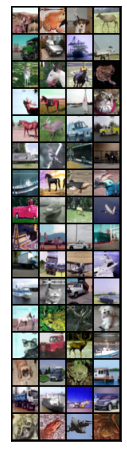

In [9]:
show_batch(train_loader)

# Handling GPU

In [10]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        for batch in self.dataloader:
            yield to_device(batch, self.device) 
    
    def __len__(self):
        return len(self.dataloader)

In [11]:
device = get_default_device()
print('device: ', device)

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

device:  cuda


# Constructing the residual network model

In [12]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool == True:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [13]:
class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128,128), conv_block(128,128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out

        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out

        out = self.classifier(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images) 
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean() 
        batch_accs = [x['val_acc'] for x in outputs] 
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
    
    def get_lr(self, optimizer):
            for param_group in optimizer.param_groups:
                return param_group['lr']

    @torch.no_grad()
    def evaluate(self, val_loader):
        self.eval()
        outputs = [model.validation_step(batch) for batch in val_loader]
        return model.validation_epoch_end(outputs)
    
    
    
    def fit(self, epochs, learning_rate, train_loader, val_loader, opt, weight_decay=0, grad_clip=None):
        torch.cuda.empty_cache()
        optimizer = opt(self.parameters(), learning_rate, weight_decay=weight_decay)
        history = [] 
        schedule = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                       learning_rate, 
                                                       epochs=epochs, 
                                                       steps_per_epoch=len(train_loader))

        for epoch in range(epochs):
            self.train()
            train_losses = []
            lrs = []

            for batch in train_loader:
                loss = self.training_step(batch)
                train_losses.append(loss)
                loss.backward()
                
                if grad_clip:
                    nn.utils.clip_grad_value_(self.parameters(), grad_clip)

                optimizer.step()
                optimizer.zero_grad()

                lrs.append(self.get_lr(optimizer))
                schedule.step()

            result = self.evaluate(val_loader)
            result['train_loss'] = torch.stack(train_losses).mean().item()
            result['lrs'] = lrs
            self.epoch_end(epoch, result)
            history.append(result)
        
        return history

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [15]:
in_channels = 3
num_classes = 10

model = to_device(ResNet9(in_channels, num_classes), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [16]:
model.evaluate(val_loader)

{'val_loss': 2.3034534454345703, 'val_acc': 0.09889240562915802}

# Training the Model

In [17]:
# Hyperparams
epochs = 10
learning_rate = 1e-3
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [18]:
history = model.fit(epochs, learning_rate, train_loader, val_loader, 
                             opt=opt_func,
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay)

Epoch [0], last_lr: 0.00028, train_loss: 1.6148, val_loss: 1.0591, val_acc: 0.6240
Epoch [1], last_lr: 0.00076, train_loss: 1.1070, val_loss: 1.0176, val_acc: 0.6596
Epoch [2], last_lr: 0.00100, train_loss: 0.8900, val_loss: 0.8383, val_acc: 0.7102
Epoch [3], last_lr: 0.00095, train_loss: 0.7353, val_loss: 0.6171, val_acc: 0.7903
Epoch [4], last_lr: 0.00081, train_loss: 0.6297, val_loss: 0.5286, val_acc: 0.8196
Epoch [5], last_lr: 0.00061, train_loss: 0.5358, val_loss: 0.4618, val_acc: 0.8410
Epoch [6], last_lr: 0.00039, train_loss: 0.4514, val_loss: 0.3925, val_acc: 0.8685
Epoch [7], last_lr: 0.00019, train_loss: 0.3679, val_loss: 0.3222, val_acc: 0.8898
Epoch [8], last_lr: 0.00005, train_loss: 0.2873, val_loss: 0.2677, val_acc: 0.9122
Epoch [9], last_lr: 0.00000, train_loss: 0.2424, val_loss: 0.2612, val_acc: 0.9148


Text(0, 0.5, 'loss')

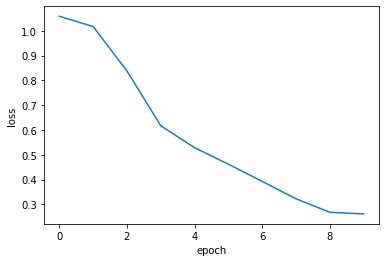

In [19]:
losses = [x['val_loss'] for x in history]
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'acc')

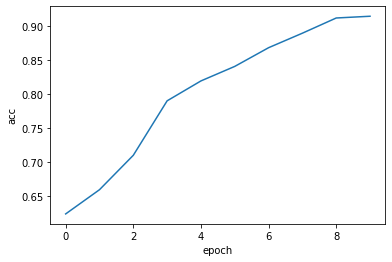

In [20]:
accs = [x['val_acc'] for x in history]
plt.plot(accs)
plt.xlabel('epoch')
plt.ylabel('acc')

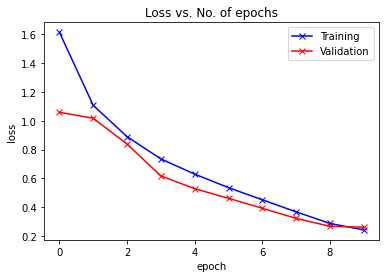

In [21]:
train_losses = [x.get('train_loss') for x in history]
val_losses = [x['val_loss'] for x in history]
plt.plot(train_losses, '-bx')
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs');

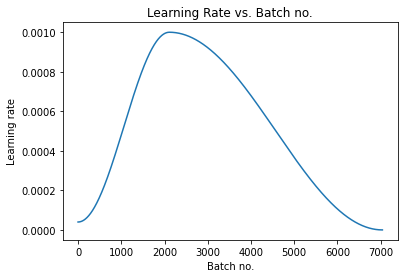

In [22]:
lrs = np.concatenate([x.get('lrs', []) for x in history])
plt.plot(lrs)
plt.xlabel('Batch no.')
plt.ylabel('Learning rate')
plt.title('Learning Rate vs. Batch no.');

# Performance on Test set

In [23]:
test_transforms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])
test_data = CIFAR10(root=".", train=False, download=True, transform=test_transforms)

Files already downloaded and verified


In [24]:
def predict_image(img, model):
    print(img.shape)
    x = to_device(img.unsqueeze(0), device)
    y = model(x)
    _, preds = torch.max(y, dim=1)
    return test_data.classes[preds[0].item()]

torch.Size([3, 32, 32])
Label: ship , Predicted: ship


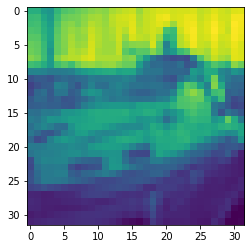

In [25]:
img, label = test_data[2]
plt.imshow(img[0])
print('Label:', test_data.classes[label], ', Predicted:', predict_image(img, model))

torch.Size([3, 32, 32])
Label: horse , Predicted: horse


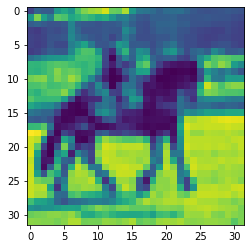

In [26]:
img, label = test_data[5000]
plt.imshow(img[0])
print('Label:', test_data.classes[label], ', Predicted:', predict_image(img, model))

In [27]:
test_loader = DeviceDataLoader(DataLoader(test_data, 32), device)
result = model.evaluate(test_loader)
result

{'val_loss': 0.28263258934020996, 'val_acc': 0.9052516222000122}